# Pneumonia Detection using Deep Learning
## Big Data for Official Statistics
### Maria Luisa Croci - 1597797


In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
from PIL import Image
import seaborn as sns
from tqdm.notebook import trange, tqdm
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import pandas as pd

# Keras Libraries
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, load_img



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [4]:
labels = ['PNEUMONIA', "NORMAL"]
img_size = 150 #fix the size of the image


#function used to convert each image into a matrix
def get_training_data(data_dir):
    data = [] 
    for label in tqdm(labels): 
        path = os.path.join(data_dir, label) #path normal and pneumonia
        class_num = labels.index(label) #0 pneum, 1 normal
        for img in tqdm(os.listdir(path)): #for img file in normal/pneumonia folder
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) #matrix of the image
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num]) #append the image matrix and his label
            except Exception as e: #pass the error
                print(e)
    return np.array(data)

In [5]:

train = get_training_data('/content/drive/My Drive/chest_xray/train')
test = get_training_data('/content/drive/My Drive/chest_xray/test')
val = get_training_data('/content/drive/My Drive/chest_xray/val')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'




OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'





OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'




OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'





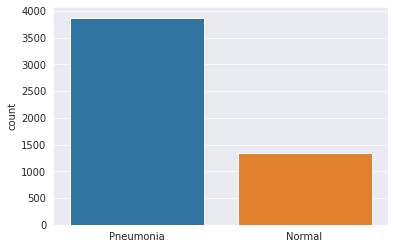

In [6]:
#count number of pneumonia and normal in train set
l = []
for i in train:
    if(i[1] == 0): #if label is 0
        l.append("Pneumonia") #append pneumonia in list
    else:
        l.append("Normal") #if label is 1 append normal in list
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

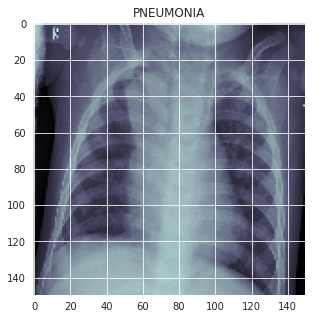

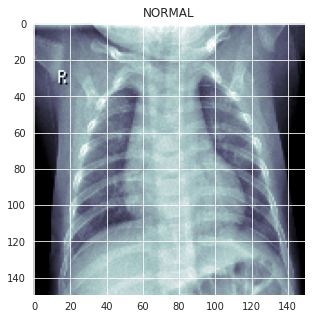

In [7]:
#show pneumonia x-ray
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='bone')
plt.title(labels[train[0][1]])

#show normal x-ray
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='bone')
plt.title(labels[train[-1][1]])

In [18]:
#separate features (matrix) from the class

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [19]:
# Normalize the data, so each pixel value lies between 0 and 1
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [20]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1) #reshape, so each element is not a list
y_train = np.array(y_train) #turn into array 

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [21]:
# data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 20%
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)
 


datagen.fit(x_train) #apply the augmentation on training features

In [22]:
#build the cnn model with 5 layers and 2 fully connected layers

## sequential provides training and inference features on this model.

model = tf.keras.Sequential() 

#Stacking layers is done by the method .add of the class Sequential

#1st convolution and pooling layer

#2D Convolution layer (spatial convolution over images)
#32 filters, kernel 3x3, relu as activation function, stride is the number of pixel the kernel shifts
#padding="same" means zero padding (instead Valid padding is no padding)

#When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers)
model.add(tf.keras.layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , 
                                 activation = 'relu' , input_shape = (150,150,1)))

#Pooling
#pool size is 2x2 window size that shift of 2 pixels over which to take the maximum
model.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))

#2nd convolution and pooling layer
model.add(tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))

#3rd convolution and pooling layer
model.add(tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))

#4th convolution and pooling layer
model.add(tf.keras.layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))

#5th convolution and pooling layer
model.add(tf.keras.layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# Flatten the layer (vectorize output of the last layer)
model.add(tf.keras.layers.Flatten())

#1st Fully Connected Layers
#units is dimensionality of the output space
#relu is non linear activation function 
model.add(tf.keras.layers.Dense(units = 128 , activation = 'relu'))

#Dropout is a technique where randomly selected neurons are ignored during training. 
#They are “dropped-out” randomly. 
#This means that their contribution to the activation of downstream neurons
#is temporally removed on the forward pass and 
#any weight updates are not applied to the neuron on the backward pass.

model.add(tf.keras.layers.Dropout(0.2))


#2nd FC has only 1 unit because it needs to predict if someone has pneumonia or not.
#The main reason why we use sigmoid function is because it exists between 0 to 1. 
#Therefore, it is especially used for models where we have to predict the probability as an output.
#Since probability of anything exists only between the range of 0 and 1, sigmoid is the right choice.

model.add(tf.keras.layers.Dense(units = 1 , activation = 'sigmoid'))

#After the model definition, it is necessary to configure the the learning process with the method .compile

# Compile the Neural network

#Adam optimization fuction is a stochastic gradient descent method
#based on adaptive estimation of first-order and second-order moments,
#that optimizes how fast our model learns the correct classification of the image. 
#It is computationally efficient, has little memory requirement 
#and is well suited for problems that are large in terms of data/parameters

#Binary cross entropy computes the loss between true labels and predicted labels. 
# It is binary since there are only two label classes (Pneumonia 0, Normal 1)
# metric is the function used to judge the performance of the model

model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

#summary of the structure of the CNN
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 38, 38, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 19, 19, 128)      

In [23]:
#Takes data & label arrays, generates batches of augmented data.

training_set = datagen.flow(x_train, y_train)
validation_generator = datagen.flow(x_val, y_val)

In [30]:
#After compiling the neural model, iterate on training data by using .fit method
#epochs 10 is the number of iterations over the training set, that is number of times that the learning algorithm will work through the entire training dataset.
#The batch size = 32 (default) is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.

history = model.fit(training_set,
                    epochs = 10 , 
                    validation_data = validation_generator)

#steps_per_epoch = 163 number of steps taken from the generator 
#as soon as one epoch is finished and next epoch has started.
#it is the total number of samples in your dataset divided by the batch size 

Epoch 1/10
163/163 [==============================] - 242s 1s/step - loss: 0.1411 - accuracy: 0.9454 - val_loss: 0.7291 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 237s 1s/step - loss: 0.1430 - accuracy: 0.9457 - val_loss: 0.8639 - val_accuracy: 0.6875
Epoch 3/10
163/163 [==============================] - 241s 1s/step - loss: 0.1280 - accuracy: 0.9532 - val_loss: 0.7446 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 242s 1s/step - loss: 0.1233 - accuracy: 0.9557 - val_loss: 1.0199 - val_accuracy: 0.6875
Epoch 5/10
163/163 [==============================] - 239s 1s/step - loss: 0.1151 - accuracy: 0.9559 - val_loss: 0.9323 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 243s 1s/step - loss: 0.1109 - accuracy: 0.9582 - val_loss: 0.9114 - val_accuracy: 0.6250
Epoch 7/10
163/163 [==============================] - 241s 1s/step - loss: 0.1134 - accuracy: 0.9588 - val_loss: 1.2252 - val_accuracy: 0.6250

In [31]:
#evaluate our model on a test set
evaluation = model.evaluate(x_test, y_test)


20/20 [==============================] - 7s 343ms/step - loss: 0.3100 - accuracy: 0.9327


In [32]:
ev = ["Loss", "Accuracy"]

for i,j in zip(ev, evaluation):
    print(i, round(j*100, 2), "%")

Loss 31.0 %
Accuracy 93.27 %


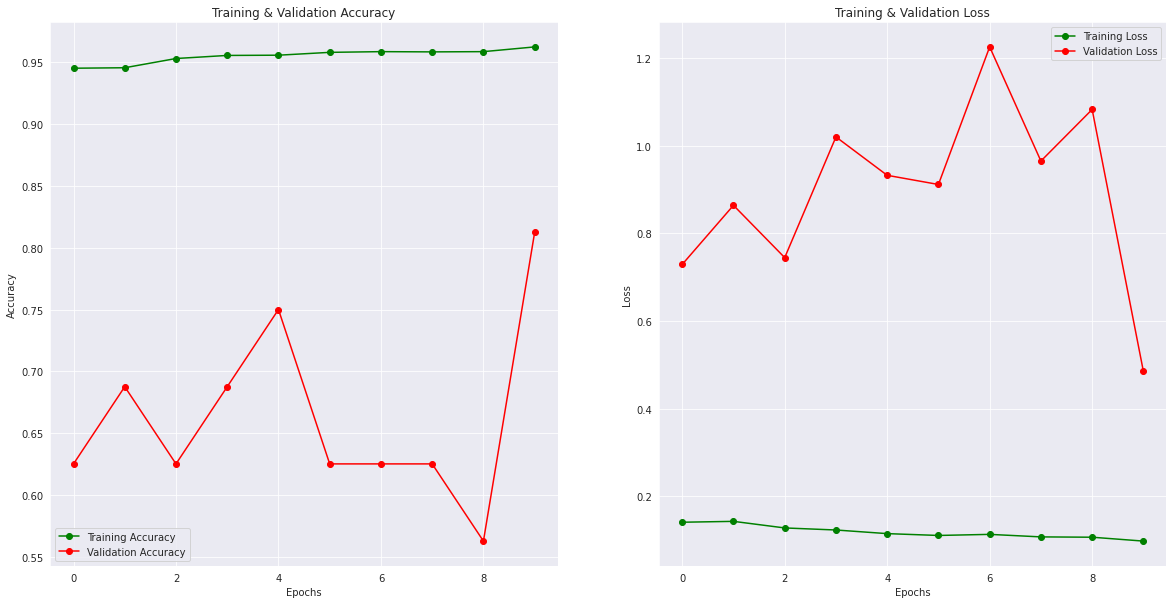

In [33]:
#plot accuracy and loss trends for both training and validation for each epoch

epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [34]:
#adopt the trained model in order to predict categorical variables 
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [35]:
#summary the measures
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.98      0.95       390
   Normal (Class 1)       0.97      0.85      0.90       234

           accuracy                           0.93       624
          macro avg       0.94      0.92      0.93       624
       weighted avg       0.93      0.93      0.93       624



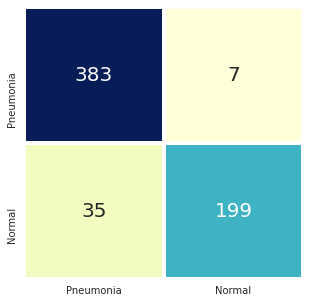

In [36]:
#get the confusion matrix 
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, index = ['Pneumonia','Normal'] , columns = ['Pneumonia','Normal'])

plt.figure(figsize = (5,5))
sns.heatmap(cm, cmap="YlGnBu", linewidth = 3 , annot = True, fmt='d', cbar=False, annot_kws={"size": 20})

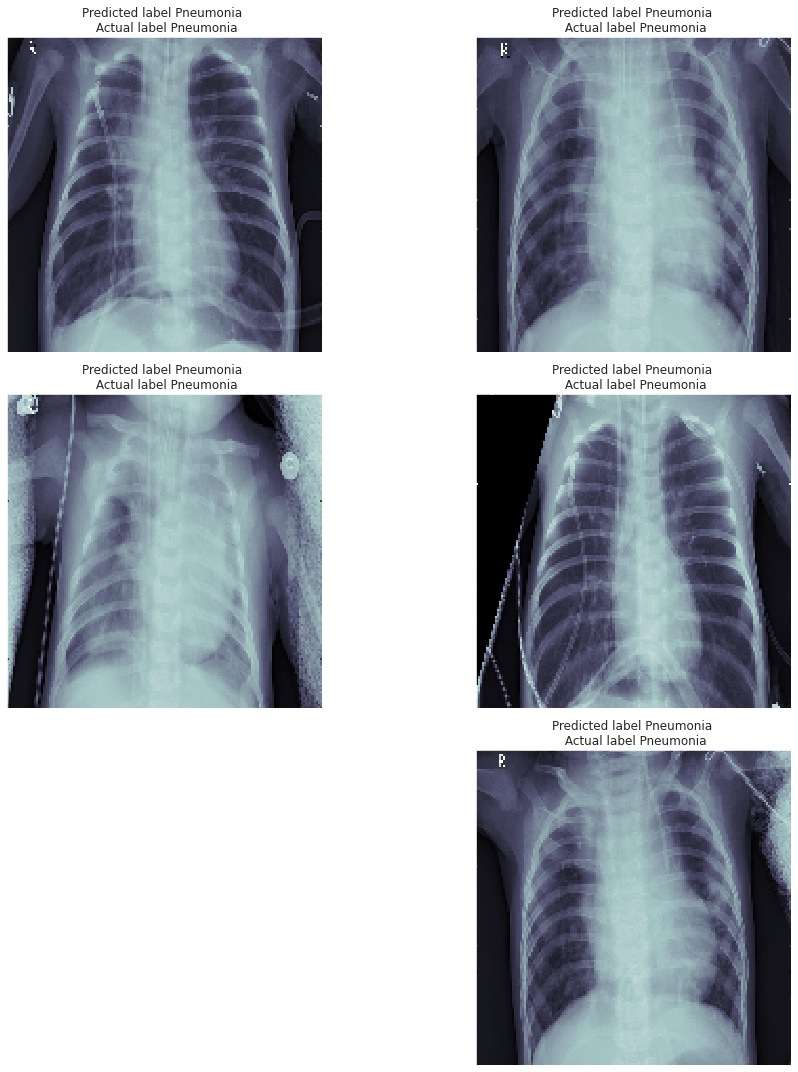

In [38]:
#plot some correct and incorrect classifications

correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

plt.figure(figsize = (15,15))

i = 0

for c in correct[:6]:
    j = []
    if predictions[c] == 0:
        j.append("Pneumonia")
    else:
        j.append("Normal")
    if y_test[c] == 0:
        j.append("Pneumonia")
    else:
        j.append("Normal")
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="bone", interpolation='none')
    plt.title("Predicted label {} \n Actual label {}".format(j[0], j[1]))
    plt.tight_layout()
    i += 1

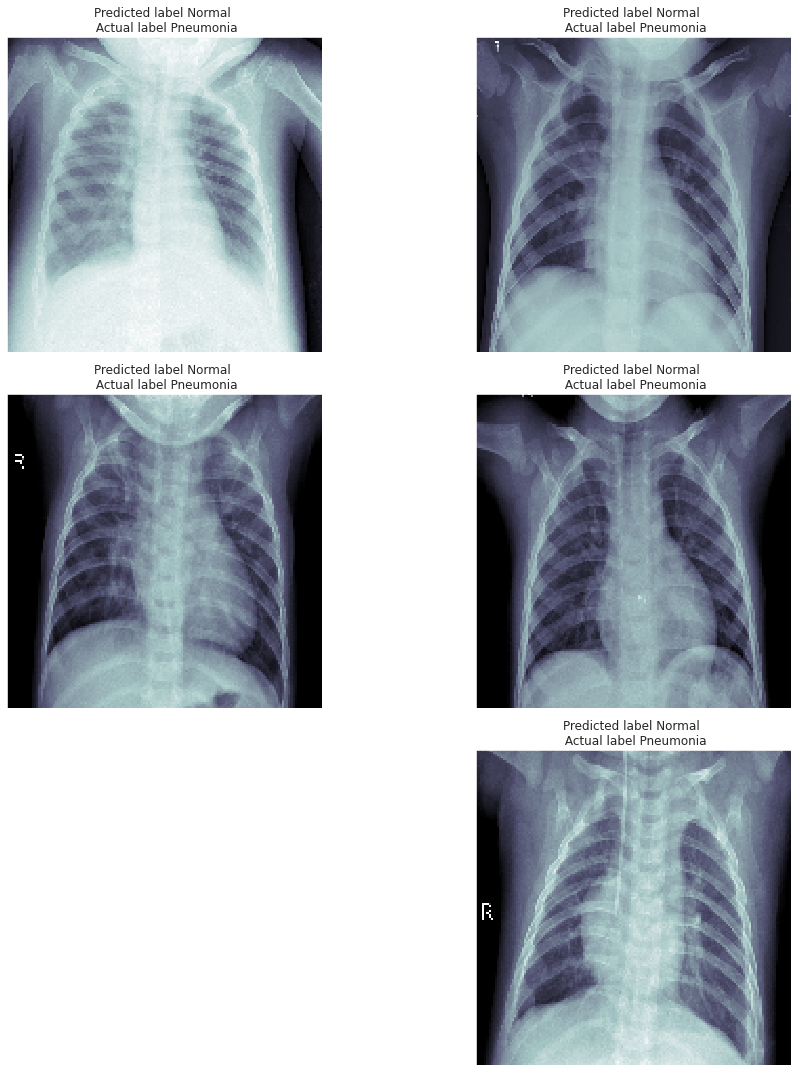

In [39]:
#Some of the Incorrectly Predicted Classes
plt.figure(figsize = (15,15))
i = 0
for c in incorrect[:6]:
    j = []
    if predictions[c] == 0:
        j.append("Pneumonia")
    else:
        j.append("Normal")
    if y_test[c] == 0:
        j.append("Pneumonia")
    else:
        j.append("Normal")
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="bone", interpolation='none')
    plt.title("Predicted label {} \n Actual label {}".format(j[0], j[1]))
    plt.tight_layout()
    i += 1